# Cards Image Dataset-Classification
[Kaggle page](https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/data)

The data is in E:\Data_and_Models\Kaggle_Cards (53 classes 7624 train, 265 test, 265 validation images 224 X 224 X 3).
The train, test and validation directories are partitioned into 53 sub directories, one for each of the 53 types of cards. The dataset also includes a csv file which can be used to load the datasets.


Plan:

* Fine-tune a pretrained image classification model
* Extract outputs from the feature extraction layers and try completing the task with gradient boosting
* Compare results


[Nets in torchvision](https://pytorch.org/vision/stable/models.html), though could look at those through timm or directly on huggingface.

The image resolution (224x224) matches many standard nets (e.g. [EfficientNet](https://pytorch.org/vision/stable/models/efficientnet.html) B0, [ResNet](https://pytorch.org/vision/stable/models/resnet.html)(s) 34 and 50).
The [RexNet family](https://github.com/clovaai/rexnet) is also all of that resolution, and although less common, supposedly more efficient in training than EfficientNet.

EfficientNet B0 and RexNet 1.0 have around 5M parameters, and EfficientNet B2 and RexNet 1.5 have around 10M.
If venturing farther, then [EfficientNetV2](https://pytorch.org/vision/stable/models/efficientnetv2.html) (the small one, which would still upscale to 384x384) would be even more efficient, but at around 20M parameters (between those of EfficientNet B4 and B5).

In [1]:
import sys
sys.path.append('..')
from pytorch_utils import *
%load_ext autoreload
%autoreload 2

In [2]:
data_path = r'E:\Data_and_Models\Kaggle_Cards'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Classification with NN

In [3]:
import timm

# The HWC -> CHW permutation seems to happen on its own (or the data info on Kaggle is wrong)
# dataloaders 0, 1, 2 are train, test and valid

# # EfficientNet B0 - 5.3M parameters
# dataloaders, classes = image_dataloaders(data_path, (transforms := (weights := tv.models.EfficientNet_B0_Weights.DEFAULT).transforms()), batch_size = 32)
# model = tv.models.efficientnet_b0(weights = weights).to(device)

# # EfficientNet B2 - 9.2M parameters
# dataloaders, classes = image_dataloaders(data_path, (transforms := (weights := tv.models.EfficientNet_B2_Weights.DEFAULT).transforms()), batch_size = 32)
# model = tv.models.efficientnet_b2(weights = weights).to(device)

# RexNet 1.0 - 4.8M parameters - https://huggingface.co/timm/rexnet_100.nav_in1k
model = timm.create_model('rexnet_100.nav_in1k', pretrained = True, num_classes = 53).eval().to(device) # Cannot use len(classes) yet
dataloaders, classes = image_dataloaders(data_path, (transforms := timm.data.create_transform(**timm.data.resolve_model_data_config(model), is_training = False)), batch_size = 32)

# # RexNet 1.5 - 9.7M parameters - https://huggingface.co/timm/rexnet_150.nav_in1k
# model = timm.create_model('rexnet_150.nav_in1k', pretrained = True, num_classes = 53).eval().to(device) # Cannot use len(classes) yet
# dataloaders, classes = image_dataloaders(data_path, (transforms := timm.data.create_transform(**timm.data.resolve_model_data_config(model), is_training = False)), batch_size = 32)

In [4]:
summary(model = model, input_size = (32, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], col_width = 20, row_settings = ['var_names'])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
RexNet (RexNet)                               [32, 3, 224, 224]    [32, 53]             --                   True
├─ConvNormAct (stem)                          [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    └─Conv2d (conv)                          [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    └─BatchNormAct2d (bn)                    [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─Identity (drop)                   [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    │    └─SiLU (act)                        [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (features)                       [32, 32, 112, 112]   [32, 1280, 7, 7]     --                   True
│    └─LinearBottleneck (0)                   [32, 32, 112, 112]   [32, 16, 112, 112]  

In [5]:
# Make the feature extractor layers ("features" in the summary) non-trainable (re-run summary above to check)
for param in model.features.parameters(): param.requires_grad = False

# # This as well for RexNet models
for param in model.stem.parameters(): param.requires_grad = False

In [6]:
# NOT NEEDED FOR REXNETS
# Inspect the classifier layers to replicate its structure
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [7]:
# NOT NEEDED FOR REXNETS

# Set the number of classes to the card ones (and reset the other parameters in the classifier layer)
model.classifier = torch.nn.Sequential(
    # EfficientNet B0
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features = 1280, out_features = len(classes), bias = True)
    # # EfficientNet B2
    # torch.nn.Dropout(p = 0.3, inplace = True),
    # torch.nn.Linear(in_features = 1408, out_features = len(classes), bias = True)
).to(device)


# The following simpler option does not complain but fails to replace the actual parameter tensor:
#   model.classifier[1].out_features = len(classes)
# And replacing just the linear layer might be biased by the pretrained dropout one
#   model.classifier[1] = torch.nn.Linear(in_features = 1280, out_features = len(classes), bias = True).to(device)

In [5]:
# Define an extra metric beside the loss
f1_fn = torchmetrics.F1Score(task = 'multiclass', num_classes = len(classes)).to(device)
accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes = len(classes)).to(device)

In [6]:
# Train the model

model_name = 'RexNet10'
extra = '0_FullRetrain_Adam001_10_epochs' # Mimicking the train_combination function format
print(f'Training {model_name}_{extra}')

set_seeds(42)
results = fit(model, train_dataloader = dataloaders[0], test_dataloader = dataloaders[1],
    optimiser = torch.optim.Adam(model.parameters(), lr = 0.001), loss_fn = nn.CrossEntropyLoss(),
    metric_name_and_fn = ('F1', f1_fn),
    # metric_name_and_fn = ('Accuracy', accuracy_fn),
    epochs = 10,
    writer = tensorboard_writer(experiment_name = 'Cards', model_name = model_name, extra = extra)
    # writer = None
)

# Timings (on GTX 970) and last-epoch metrics (not necessarily best):
#   - EfficientNet B0: 7:43, 25 per epoch
#       train_loss: 1.4660 | train_metric: 0.5907 | test_loss: 1.8822 | test_metric: 0.4228
#   - EfficientNet B2: 21:50, 2:11 per epoch
#       train_loss: 1.4443 | train_metric: 0.6009 | test_loss: 1.8505 | test_metric: 0.4279
#   - RexNet 1.0: 7:21, 44 per epoch
#       train_loss: 1.5509 | train_metric: 0.5605 | test_loss: 2.0055 | test_metric: 0.4186
#   - RexNet 1.5: 8:00, 48 per epoch
#       train_loss: 0.8666 | train_metric: 0.7560 | test_loss: 1.5839 | test_metric: 0.4884
#   - RexNet 1.0 FULLY RETRAINED: 30:49, 3:04 per epoch
#       train_loss: 0.0903 | train_metric: 0.9732 | test_loss: 0.2218 | test_metric: 0.9390

Training RexNet10_0_FullRetrain_Adam001_10_epochs
[INFO] Created SummaryWriter, saving to: runs\2024-04-08\Cards\RexNet10\0_FullRetrain_Adam001_10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 training batches: 0it [00:00, ?it/s]

Epoch 1 testing batches: 0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.7339 | train_metric: 0.5124 | test_loss: 0.5602 | test_metric: 0.8314


Epoch 2 training batches: 0it [00:00, ?it/s]

Epoch 2 testing batches: 0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.5716 | train_metric: 0.8264 | test_loss: 0.2966 | test_metric: 0.9147


Epoch 3 training batches: 0it [00:00, ?it/s]

Epoch 3 testing batches: 0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.3233 | train_metric: 0.9004 | test_loss: 0.2243 | test_metric: 0.9198


Epoch 4 training batches: 0it [00:00, ?it/s]

Epoch 4 testing batches: 0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.2093 | train_metric: 0.9327 | test_loss: 0.1722 | test_metric: 0.9495


Epoch 5 training batches: 0it [00:00, ?it/s]

Epoch 5 testing batches: 0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.1696 | train_metric: 0.9484 | test_loss: 0.2843 | test_metric: 0.9217


Epoch 6 training batches: 0it [00:00, ?it/s]

Epoch 6 testing batches: 0it [00:00, ?it/s]

Epoch: 6 | train_loss: 0.1520 | train_metric: 0.9536 | test_loss: 0.2251 | test_metric: 0.9267


Epoch 7 training batches: 0it [00:00, ?it/s]

Epoch 7 testing batches: 0it [00:00, ?it/s]

Epoch: 7 | train_loss: 0.0993 | train_metric: 0.9685 | test_loss: 0.1524 | test_metric: 0.9668


Epoch 8 training batches: 0it [00:00, ?it/s]

Epoch 8 testing batches: 0it [00:00, ?it/s]

Epoch: 8 | train_loss: 0.0992 | train_metric: 0.9704 | test_loss: 0.1931 | test_metric: 0.9475


Epoch 9 training batches: 0it [00:00, ?it/s]

Epoch 9 testing batches: 0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.0868 | train_metric: 0.9748 | test_loss: 0.2121 | test_metric: 0.9425


Epoch 10 training batches: 0it [00:00, ?it/s]

Epoch 10 testing batches: 0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.0903 | train_metric: 0.9732 | test_loss: 0.2218 | test_metric: 0.9390


In [7]:
# save_model(model, fr'{data_path}\Models', f'{model_name}_{extra}.pth')

[INFO] Saving model to: E:\Data_and_Models\Kaggle_Cards\Models\RexNet10_0_FullRetrain_Adam001_10_epochs.pth


WindowsPath('E:/Data_and_Models/Kaggle_Cards/Models/RexNet10_0_FullRetrain_Adam001_10_epochs.pth')

In [11]:
# Recreate the model and load the saved parameters

# # EfficientNet B0
# model_name, extra = 'EffNetB0', '0_First_Adam001_10_epochs'
# model = tv.models.efficientnet_b0(weights = (weights := tv.models.EfficientNet_B0_Weights.DEFAULT)).to(device)
# transforms = weights.transforms()
# for param in model.features.parameters(): param.requires_grad = False
# model.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p = 0.2, inplace = True),
#     torch.nn.Linear(in_features = 1280, out_features = len(classes), bias = True)
# ).to(device)

# # EfficientNet B2
# model_name, extra = 'EffNetB2', '0_First_Adam001_10_epochs'
# model = tv.models.efficientnet_b0(weights = (weights := tv.models.EfficientNet_B2_Weights.DEFAULT)).to(device)
# transforms = weights.transforms()
# for param in model.features.parameters(): param.requires_grad = False
# model.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p = 0.3, inplace = True),
#     torch.nn.Linear(in_features = 1408, out_features = len(classes), bias = True)
# ).to(device)

# RexNet 1.0
model_name, extra = 'RexNet10', '0_First_Adam001_10_epochs'
model = timm.create_model('rexnet_100.nav_in1k', pretrained = True, num_classes = 53).eval().to(device) # Cannot use len(classes) yet
transforms = timm.data.create_transform(**timm.data.resolve_model_data_config(model), is_training = False)
for param in model.features.parameters(): param.requires_grad = False
for param in model.stem.parameters(): param.requires_grad = False

# # RexNet 1.5
# model_name, extra = 'RexNet15', '0_First_Adam001_10_epochs'
# model = timm.create_model('rexnet_150.nav_in1k', pretrained = True, num_classes = 53).eval().to(device) # Cannot use len(classes) yet
# transforms = timm.data.create_transform(**timm.data.resolve_model_data_config(model), is_training = False)
# for param in model.features.parameters(): param.requires_grad = False
# for param in model.stem.parameters(): param.requires_grad = False

# model.classifier
model.load_state_dict(torch.load(fr'{data_path}\Models\{model_name}_{extra}.pth'))

<All keys matched successfully>

In [13]:
from PIL import Image

def plot_img_preds(model: torch.nn.Module, image_path: str, class_names: list[str], transform: tv.transforms, device: torch.device = device):
    '''Take in a trained model, class names, image path, image size, a transform and target device'''
    img = Image.open(image_path)

    model.to(device)
    model.eval()
    with torch.inference_mode():
        # Transform and prepend "batch" dimension (-> [batch_size, color_channels, height, width])
        transformed_image = transform(img).unsqueeze(dim = 0)
        target_image_pred = model(transformed_image.to(device))

    # logits -> probabilities -> labels
    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

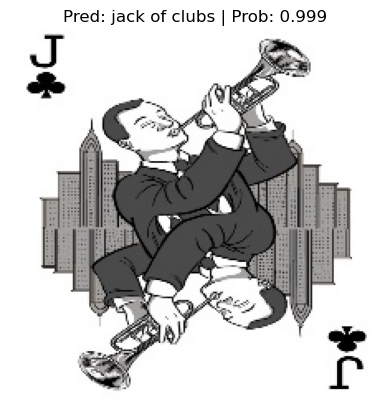

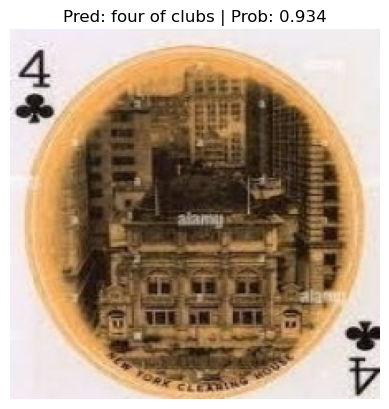

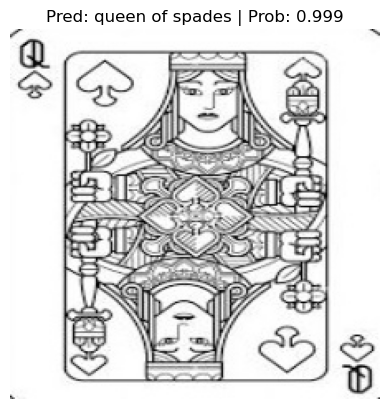

In [14]:
import random

test_image_path_list = list(Path(fr'{data_path}\train').glob("*/*.jpg"))

for image_path in random.sample(population = test_image_path_list, k = 3):
    plot_img_preds(model = model, image_path = image_path, class_names = classes, transform = transforms)

* Add initial EDA
* Try different hyperparams
* Replace all plotting with Altair
* Try Lightning
* Use LightGBM instead of the classifier layers
* Visualise wrong outputs